Import library dan load data yang akan dibutuhkan.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['netflix_titles.csv']))

Saving netflix_titles.csv to netflix_titles.csv


**Tf-idf and document similarity**

Kemudian mendefinisikan tf-idf vectorizer parameter dan meng-convert description menjadi matrix tf-idf. Vectorizer menggunakan stopwords untuk menghilangkan kata seperti 'a' atau 'the'.

In [3]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(list(data.description))

Terms adalah vocabulary.

In [4]:
terms = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


dist didefinisikan sebagai 1 - persamaan cosinus dari setiap dokumen. Kesamaan cosine diukur terhadap matriks tf-idf dan dapat digunakan untuk menghasilkan ukuran kesamaan antara setiap dokumen dan dokumen lainnya dalam korpus (setiap description di antara description). Mengurangkannya dari 1 memberikan jarak kosinus yang akan saya gunakan untuk memplot pada bidang euclidean (2-dimensi).

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X[:100])

**K-means clustering**

Dengan menggunakan matrix tf-idf, dapat dilakukan algoritma pengelompokkan untuk lebih memahami struktur tersembunyi di dalam description.

In [6]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
clusters = model.labels_.tolist()
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

Membuat dataframe yang terdiri dari title, type_show, description dan cluster. Hanya dibatasi 200 data.

In [7]:
netflix = { 'title': list(data.title)[:100], 'type_show': list(data.type)[:100], 'description': list(data.description)[:100], 'cluster': clusters[:100] }
frame = pd.DataFrame(netflix, index = [clusters[:100]] , columns = ['title', 'type_show', 'description', 'cluster'])

Contoh data yang sudah ter-cluster.

In [8]:
from __future__ import print_function

print("Top terms per cluster:")
print()

for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :5]:
        print(terms[ind])
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[[i]]['title']:
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace


print()
print()

Top terms per cluster:

Cluster 0:
life
family
world
documentary
series


Cluster 0 titles: Norm of the North: King Sized Adventure, #realityhigh, Automata, Fabrizio Copano: Solo pienso en mi, Fire Chasers, Good People, Joaquín Reyes: Una y no más, Kidnapping Mr. Heineken, Krish Trish and Baltiboy, Krish Trish and Baltiboy: Battle of Wits, Krish Trish and Baltiboy: Best Friends Forever, Krish Trish and Baltiboy: Comics of India, Krish Trish and Baltiboy: Oversmartness Never Pays, Krish Trish and Baltiboy: Part II, Manhattan Romance, Castle of Stars, City of Joy, Laddaland, Next Gen, Sierra Burgess Is A Loser, The Most Assassinated Woman in the World, Cézanne et moi, Archibald's Next Big Thing, Article 15, Care of Kancharapalem, Ee Nagaraniki Emaindi, Kill Me If You Dare, The Spy, PK, American Factory: A Conversation with the Obamas, Bangkok Traffic (Love) Story, I Fine... Thank You... Love You, Phobia 2, Marc Maron: Too Real, The World We Make, Man Up, Frequency, Mo Gilligan: Momentum,

**Multidimensional scaling**

Mengubah matrix dist menjadi 2-dimensi array.

In [9]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

**Visualizing document clusters**

Memvisualisasikan output document cluster menggunakan matplotlib.

In [10]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#45b6fe'}

cluster_names = {0: 'New, life, family, world, friends', 
                 1: 'Save, fight, american, future, brothers', 
                 2: 'Drama, stories, set, writer, single', 
                 3: 'Yound, man, women, life, father', 
                 4: 'Documentary, follows, explores, series, world'}

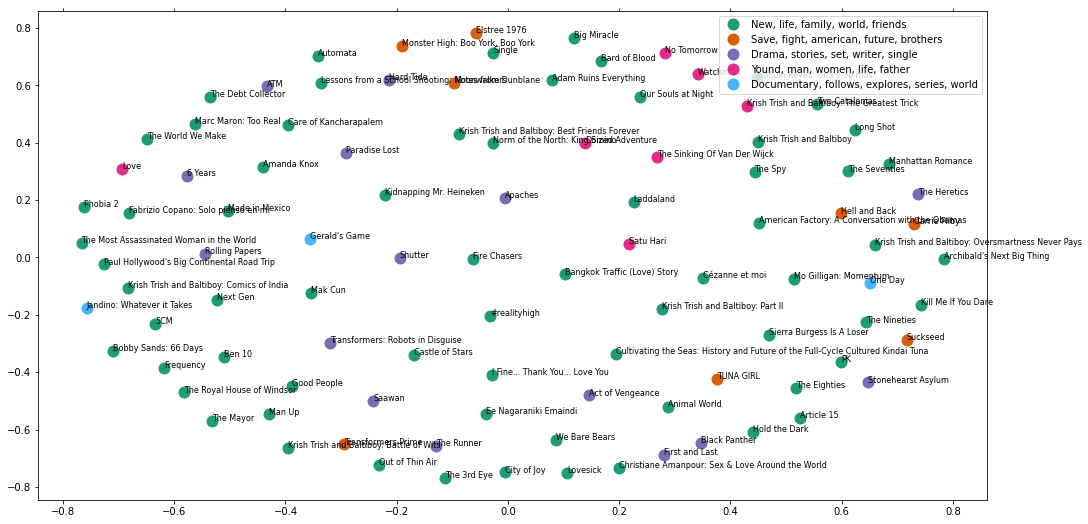

In [11]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters[:100], title=list(data.title)[:100])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)